# Train Model in Pipeline

This script allows the user to deploy a configured Training Pipeline to train a model based on a selected machine learning algorithm and logs the model in mlflow using the mlflow sqlite:///mlflow.db as the back end local store for model tracking and model registry. Model staging and versioning is done inside mlflow via API or UI. The make_predictions.ipynb and deploy_model.sh files allow user to deploy a model locally as a REST endpoint.

Note: The pipeline preprocessing steps are explicitly demonstrated in the EDA Notebook.ipynb file.

### Import Necessary Packages & Modules

In [4]:
# data manipulation
import pandas as pd
import numpy as np
import time
import os
import joblib

# from Scikit-learn import train_test_split to split the Train data into traion and test (validation) sets
from sklearn.model_selection import train_test_split

# from Keras to build keras classifier model
from keras.models import Sequential
from keras.layers import Dense
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# from Scikit-learn to build RandomForest Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier


#import mlflow

# The configuration script initializes the Data Preprocessing & Feature Engineering 
# Pipepline
# It returns the list of Model Features and the Pipeline Preprocessing steps
from pipeline_configuration import pipe_configuration 


# The intent is to separate Algorithm Configuration from this main Train.ipynb file
# but this part is not complete yet.
# So, commenting out. Algorithm configuration is done inside this script for now!
from model_config.KerasClassifier_Config import KerasClassifierModel
from model_config.RandomForestClassifier_Config import RandomForestClassifierModel

# The TrainingPipeline Class inherits from Sckit-learn Pipeline and performs the 
# last step (model.fit()) 
# in the Training Piepline. It also uses the mlflow context to log model metrics, 
# parameters and artifacts to mlflow. The mlflow sqlite:///mlflow.db is used as 
# the local store for tracking and registery.
from train_pipeline import TrainingPipeline


In [5]:
# Get list of Model Features and the Pipeline Preprocessing steps
FEATURES, PIPESTEPS = pipe_configuration()

# Set random state to be able to reproduce the results of the 
# research environment (EDA Notebook)
random_state = 35

In [6]:
# Specify training algorithm. Current options supported are 
# ["RandomForestClassifier", "KerasClassifier"]
training_algo = "RandomForestClassifier" #  "KerasClassifier" 

# Specify if performing Hyper Parameter tuning or not. If set to True, a 
# RandomizedSearch is performed using parametrs 
# supplied by the user and a final model is trained & logged based on the best 
# parameters found.
hyper_parameter_tuning = False

### Import Train Data and Split into Train & Test for Model Development

In [9]:
# load Train dataset
Train_data = pd.read_csv('Train.csv')

Train_data.drop('ID',inplace=True, axis=1)

# Get the unique Segmentation Labels
segmentation_labels = np.sort(Train_data['Segmentation'].unique())


X_train, X_test, y_train, y_test = train_test_split(Train_data[FEATURES], 
                                                    Train_data['Segmentation'], 
                                                    test_size=0.2, 
                                                    random_state=random_state) 

#X_train = Train_data[FEATURES]

# rows and columns of the train data
print('Shape of Imported Train Data: {}'.format(Train_data.shape))
print('=========================================================')
print('======================= X_train Data ====================')
print(X_train.head())
print('=========================================================')
print('======================= X_test Data ====================')
print(X_test.head())

Shape of Imported Train Data: (8068, 10)
======================= X_train Data ====================
      Gender Ever_Married  Age Graduated  Profession  Work_Experience  \
1201    Male          Yes   30       Yes  Healthcare              NaN   
2937  Female          Yes   51        No    Engineer              NaN   
943     Male          Yes   88       Yes      Lawyer              NaN   
3277  Female           No   42       Yes      Artist              1.0   
676   Female          Yes   46       Yes      Artist              1.0   

     Spending_Score  Family_Size  Var_1  
1201            Low          6.0  Cat_6  
2937        Average          3.0  Cat_4  
943             Low          NaN  Cat_6  
3277            Low          2.0  Cat_6  
676         Average          2.0  Cat_6  
======================= X_test Data ====================
      Gender Ever_Married  Age Graduated     Profession  Work_Experience  \
368   Female           No   18        No     Healthcare              9.0   
5

### Configure Model for Training Based on Selected Algorithm

In [10]:
if training_algo == "KerasClassifier":
    # define baseline model
    def keras_model():
        # create model
        model = Sequential()
        model.add(Dense(hidden_neurons, input_dim=len(FEATURES), 
                        activation=hidden_activation))
        model.add(Dense(output_neurons, activation=output_activation))
        # Compile model
        model.compile(loss='categorical_crossentropy', 
                      optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
                      metrics=['accuracy'])
        return model
    
    if hyper_parameter_tuning:
        
        # Parameters to search
        hidden_neurons = 500
        epochs = [10, 25]
        batch_size = [500, 1000]
        
        # Parameters to leave constant
        hidden_activation = 'relu'
        output_activation = 'softmax'
        #optimizer = 'adam'
        output_neurons = len(segmentation_labels)
        
        param_grid = {
                      'epochs': epochs,
                      'batch_size': batch_size} #'units':hidden_neurons,
        
        classifier = KerasClassifier(build_fn=keras_model(), 
                                     epochs=epochs, 
                                     batch_size=batch_size, 
                                     verbose=1)
        
        estimator_model = RandomizedSearchCV(estimator = classifier, 
                                             param_distributions = param_grid,
                                               cv = 10, verbose=2, 
                                             random_state=random_state, 
                                             n_jobs = -1)
        
    else:
        
        hidden_neurons = 1000
        hidden_activation = 'relu'
        output_neurons = len(segmentation_labels)
        output_activation = 'softmax'
        epochs = 10
        batch_size = 8000
        learning_rate = 0.0001

        estimator_model = KerasClassifier(build_fn=keras_model, 
                                          epochs=epochs, 
                                          batch_size=batch_size, 
                                          verbose=1)

    
    # Make a list of Parameters to log in Mlflow
    run_parameters = {'hidden_neurons':hidden_neurons,
                      'hidden_activation': hidden_activation,
                      'output_neurons': output_neurons,
                      'output_activation': output_activation,
                      'epochs': epochs,
                      'batch_size': batch_size,
                     'learning_rate': learning_rate}
    
    
    # Adding the last step in the training Pipeline
    _, PIPESTEPS = configuration()
    PIPESTEPS.append(('estimator',estimator_model))  


In [11]:
if training_algo == "RandomForestClassifier":
    
    random_state = random_state # for reproducibility
    
    if hyper_parameter_tuning:
        # define random parameters grid
        n_estimators = [5,21,51,101,400] # number of trees in the random forest
        max_features = ['auto', 'sqrt'] # number of features in consideration at every split
        max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
        min_samples_split = [2, 6, 10] # minimum sample number to split a node
        min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
        bootstrap = [True, False] # method used to sample data points
        
        # keys need formatting due to nested estimators inside a 
        # RandomizedSearchCV function
        param_grid = {'estimator__n_estimators': n_estimators,
                        'estimator__max_features': max_features,
                        'estimator__max_depth': max_depth,
                        'estimator__min_samples_split': min_samples_split,
                        'estimator__min_samples_leaf': min_samples_leaf,
                        'estimator__bootstrap': bootstrap
                      }
        
        classifier = OneVsRestClassifier(
                                        RandomForestClassifier(random_state=random_state)
                                        )
        estimator_model = RandomizedSearchCV(
                                    estimator = classifier, 
                                    param_distributions = param_grid,
                                   n_iter = 5, cv = 5, verbose=2, 
                                    random_state=random_state, n_jobs = -1)
        
        run_parameters = {}  # List of run_parameters will come from the best parameters found 
    
    else:
        
        n_estimators = 400 
        max_features = 'auto'
        max_depth = 120 
        min_samples_split = 10
        min_samples_leaf = 4
        bootstrap = False
        
#         estimator_model = OneVsRestClassifier(
#                                 RandomForestClassifier(n_estimators = n_estimators, 
#                                                        min_samples_split = min_samples_split,
#                                                         min_samples_leaf= min_samples_leaf, 
#                                                        max_features = max_features,
#                                                      max_depth= max_depth, 
#                                                        bootstrap=bootstrap,
#                                                        random_state=random_state)
#                                                         )

        # Validation - Using default parameters here to 
        #compare model performance on Test data with EDA Notebook
        estimator_model = OneVsRestClassifier(
                                        RandomForestClassifier(random_state=random_state)
                                        )
    
        # Make a list of Parameters to log in Mlflow
        run_parameters = {'n_estimators':n_estimators,
                          'max_features': max_features,
                          'max_depth': max_depth,
                          'min_samples_split': min_samples_split,
                          'min_samples_leaf': min_samples_leaf,
                          'bootstrap': bootstrap,
                          }
    
    # Adding the last step in the training Pipeline
    _, PIPESTEPS = pipe_configuration()
    PIPESTEPS.append(('estimator',estimator_model))  

*Note:* The intention is to wrap each of the above algorithm selection sections into different python files so that they are imported into this script to have a cleaner code. The python files should be located in the model_config folder where the user will input all necessary algorithm training configurations from the python scripts rather than doing it from inside this Train.py file. Below is an unfinished section of code showing how the imported algorithm/model configurations will be used.

In [12]:
# if training_algo == "KerasClassifier":
#     random_state = 35 # for reproducibility
#     KerasModel = KerasClassifierModel(segmentation_labels,FEATURES,random_state)
#     if hyper_parameter_tuning:
#         #estimator_model, run_parameters 
#         estimator_model, run_parameters = KerasModel.hyper_parameter_tuning()
#     else:
#         estimator_model, run_parameters = KerasModel.build_base_model()
#     # Adding the last step in the training Pipeline
#     _, PIPESTEPS = configuration()
#     PIPESTEPS.append(('estimator',estimator_model)) 

### Train Model

In [13]:
# Create a naming convention for experiment runs to be logged in mlflow.
# These information is passed to the TrainingPipeline Class 
# where the model logging into mlflow takes place.
clock_time = time.ctime().replace(' ', '-')
experiment_name = 'Exxon_Model'
run_name = 'Train-Run-' + clock_time
print(run_name)

Train-Run-Tue-Sep-13-13:38:07-2022


In [14]:
# Instantiate the TrainingPipeline class with all the Pipeline Steps 
# (which now already includes the final model.fit() step)
train_pipeline = TrainingPipeline(steps=PIPESTEPS)
train_pipeline.fit(X_train, y_train)

TrainingPipeline(steps=[('mean_imputation',
                         MeanMedianImputer(imputation_method='mean',
                                           variables=['Work_Experience',
                                                      'Family_Size'])),
                        ('frequent_imputation',
                         CategoricalImputer(imputation_method='frequent',
                                            variables=['Ever_Married',
                                                       'Graduated',
                                                       'Profession',
                                                       'Var_1'])),
                        ('binary_encoding',
                         OneHotEncoder(drop_last_binary=True,
                                       variables=['Gender', 'Ever_Married',
                                                  'Graduated'])),
                        ('countfreq',
                         CountFrequencyEncoder(encoding_method='frequency',
                                               variables=['Profession',
                                                          'Var_1'])),
                        ('mapper_spending_score',
                         Mapper(mappings={'Average': 2, 'High': 3, 'Low': 1},
                                variables=['Spending_Score'])),
                        ('scaler', MinMaxScaler()),
                        ('estimator',
                         OneVsRestClassifier(estimator=RandomForestClassifier(random_state=35)))])

### Log Trained Model

If hyper_parameter_tuning was set to False, the model is trained based on user supplied input and then logged into mlflow. If hyper_parameter_tuning is True, a RandomSearch is performed based on the grid parameters supplied by user and a final model is trained with the best parameters found. The final tuned model is then logged into mlflow tracking. 

Model Accuracy: 0.4919454770755886
=============== Classification Report ==================================
              precision    recall  f1-score   support

           A      0.400     0.472     0.433       375
           B      0.409     0.339     0.371       386
           C      0.499     0.493     0.496       361
           D      0.623     0.626     0.625       492

    accuracy                          0.492      1614
   macro avg      0.483     0.483     0.481      1614
weighted avg      0.492     0.492     0.491      1614



C:\Users\aaboa\anaconda3\lib\site-packages\mlflow\models\signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)


Run - Train-Run-Tue-Sep-13-13:38:07-2022 is logged to Experiment - Exxon_Model


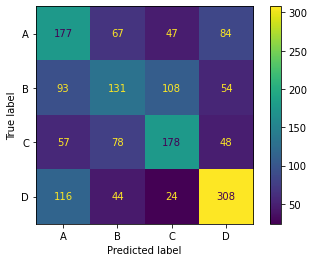

In [15]:
trained_pipeline_save_path = r'./Trained_Pipeline.pkl'

if hyper_parameter_tuning:
    
    def format_best_params_keys(best_param_dict):
        '''
        Helper function to format extra strings in the dictionary keys
        due to nested estimator objects inside RandomizedSearchCV
        '''
        best_params_copy = best_param_dict.copy()
        for k,v in best_params_copy.items():
            print(k)
            best_param_dict[k.split('__')[1]] = v
            #print(best_params)
            del best_param_dict[k]
        return best_param_dict
    
     
    print ('Parameter Search Grid: ', param_grid, '\n')
    # print the best parameters
    best_params = train_pipeline.get_params()['estimator'].best_params_
    print ('Best Parameters: ', best_params, ' \n')
    best_params = format_best_params_keys(best_params)
    
    if training_algo == "RandomForestClassifier":
        # Get the best parameters from trained pipeline estimator object
        n_estimators = best_params['n_estimators']
        min_samples_split = best_params['min_samples_split']
        min_samples_leaf = best_params['min_samples_leaf']
        max_features = best_params['max_features']
        max_depth = best_params['max_depth']
        bootstrap = best_params['bootstrap']
        
        # Configure a New Model based on best parameters
        tuned_model = OneVsRestClassifier(
                                        RandomForestClassifier(n_estimators = n_estimators, 
                                                    min_samples_split = min_samples_split,
                                                     min_samples_leaf= min_samples_leaf, 
                                                     max_features = max_features,
                                                     max_depth= max_depth, bootstrap=bootstrap)
                                        )
        
        # Make a dictionary of the best run parameters for logging into Mlflow
        run_parameters = {"n_estimators" : n_estimators,
                            "min_samples_split" : min_samples_split,
                            "min_samples_leaf" : min_samples_leaf,
                            "max_features" : max_features,
                            "max_depth" : max_depth,
                            "bootstrap" : bootstrap}
    
    if training_algo == "KerasClassifier":
        # Get the best parameters from trained pipeline estimator object
        
         # Configure a New Model based on best parameters
        tuned_model = None
          
    
    # Adding the last step in the training Pipeline
    _, PIPESTEPS = pipe_configuration() # Load the Preprocessing Pipeline Steps
    PIPESTEPS.append(('estimator',tuned_model))  # Add the estimator step
    train_pipeline_tuned = TrainingPipeline(steps=PIPESTEPS)
    # Train a new model based on the best parameters from hyperparamter search
    train_pipeline_tuned.fit(X_train, y_train)
    joblib.dump(train_pipeline_tuned, trained_pipeline_save_path)
    train_pipeline_tuned.log_model('estimator', X_test, y_test, trained_pipeline_save_path,
                                   segmentation_labels, experiment_name, 
                                   run_name, run_params=run_parameters)
    
else:
    # if no hyper parameter tuning, log trained model right away
    joblib.dump(train_pipeline,trained_pipeline_save_path)
    train_pipeline.log_model('estimator', X_test, y_test, trained_pipeline_save_path,
                             segmentation_labels, experiment_name, 
                             run_name, run_params=run_parameters)